## Object Detection - Tensorflow Models
- code reference taken from - https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html#sphx-glr-auto-examples-plot-object-detection-saved-model-py

In [28]:
#import statements
import numpy as np
from PIL import Image
%matplotlib inline

import cv2

from pathlib import Path

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import bbox_visualizer as bbv
#img_bbox = bbv.draw_rectangle(img_arr, [427, 347, 1278, 672])

### Model Name List

In [29]:
model_name_list = [
    #('centernet_hg104_1024x1024_coco17_tpu-32', '20200713'),
    #('centernet_hg104_512x512_coco17_tpu-8', '20200711'),
    #('centernet_resnet50_v1_fpn_512x512_coco17_tpu-8', '20200711'),
    #('centernet_resnet50_v2_512x512_coco17_tpu-8', '20200711'),
    #('efficientdet_d0_coco17_tpu-32', '20200711'),
    ('ssd_mobilenet_v2_320x320_coco17_tpu-8', '20200711'),
    #('faster_rcnn_resnet50_v1_640x640_coco17_tpu-8', '20200711'),
    #('mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8', '20200711')
    #('extremenet', '20200711') some error here, seems like extremenet does not have saved model dir in c/users/shubham/keras
]

In [30]:
dataset_path = Path("../../../dataset/object_detection/test")

### Download the COCO Labels

In [31]:
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

In [32]:
PATH_TO_LABELS

'C:\\Users\\shubham\\.keras\\datasets\\mscoco_label_map.pbtxt'

### Load label map data (for plotting)

In [33]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [23]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

### Download model from tensorflow.org/models
- More models can be found in the TensorFlow 2 Detection Model Zoo. To use a different model you will need the URL name of the specific model. This can be done as follows:
1. Right click on the Model name of the model you would like to use;
2. Click on Copy link address to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz;
4. Copy the XXXXXXXXX part of the link and use it to replace the value of the MODEL_NAME variable in the code shown below;
5. Copy the YYYYYYYY part of the link and use it to replace the value of the MODEL_DATE variable in the code shown below.

In [34]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

def download_models(model_name_list):
    model_dir_path_dict = {}
    for model_name in model_name_list:
        path = download_model(model_name[0], model_name[1])
        model_dir_path_dict[model_name[0]] = path
        print("downloaded {0}".format(model_name[0]))
    return model_dir_path_dict


#use below list to know model name and where it is downloaded locally
model_dir_path_dict = download_models(model_name_list)

downloaded ssd_mobilenet_v2_320x320_coco17_tpu-8


### Load the downloaded models from directories

In [35]:
def load_images_batch(batch_size):
    batch_images = []
    counter = 1
    for image_name in os.listdir(dataset_path):
        img = Image.open(dataset_path/image_name)
        #TO-DO : pre run this step of converting to RGB and remove from here
        rgb_im = img.convert('RGB')
        batch_images.append((image_name, rgb_im))
        if counter % batch_size == 0:
            yield batch_images
        counter = counter + 1

def load_model(model_name, model_dir):
    print(model_dir)
    path_to_saved_model = model_dir + "/saved_model"

    print('Loading model...', end='')
    start_time = time.time()

    # Load saved model and build the detection function
    detect_fn = tf.saved_model.load(path_to_saved_model)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))
    return detect_fn



def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

def detect_objects(model, pil_images_tuple):
    #works on single image
    # use Image.fromarray(image_np) for converting below numpy arr img to pil img
    detections_list = []
    for pil_img_tuple in pil_images_tuple:
        image_np = np.array(pil_img_tuple[1])

        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
        input_tensor = tf.convert_to_tensor(image_np)
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis, ...]

        # input_tensor = np.expand_dims(image_np, 0)
        detections = model(input_tensor)
        detections_list.append((pil_img_tuple[0], detections))
    return detections_list

def process_detections(detections_tuple_list):
    # works on list of detections
    processed_detections_list = []
    for detections_tuple in detections_tuple_list:
        detections = detections_tuple[1]
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                       for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        processed_detections_list.append((detections_tuple[0], detections))
    return processed_detections_list

def visualise_results(detections, image_np, use_normalized_coordinates=True):
    # detections - single image detection result from a model, this detection object should be from the model inference result
    # image_np - numpy image
    # visualise single image results
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    # detection box - ymin, xmin, ymax, xmax
    # denormalise using - (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    image_np_with_detections = image_np.copy()
    
    pil_img = Image.fromarray(image_np_with_detections)
    width, height = pil_img.size
    print("before vis shape ", end='')
    print(width, height)
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=use_normalized_coordinates,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)
    
    #plt.figure()
    
    pil_img = Image.fromarray(image_np_with_detections)
    width, height = pil_img.size
    print("after vis shape ", end='')
    print(width, height)
    
    plt.imshow(image_np_with_detections)
    plt.show()

In [36]:
def run_inference(model, images_tuple):
    detections_list = detect_objects(model, images_tuple)
    detections_list = process_detections(detections_list)
    #process detections object to output list as per your need
    return detections_list

In [38]:
batch_images = next(load_images_batch(3))

In [39]:
model = None

for m in model_dir_path_dict:
    model = load_model(m, model_dir_path_dict[m])

C:\Users\shubham\.keras\datasets\ssd_mobilenet_v2_320x320_coco17_tpu-8
Loading model...Done! Took 42.943129539489746 seconds


In [40]:
detection_result = run_inference(model, batch_images)

In [41]:
def get_image_size(image_name, batch_img_tuple):
    # returns the image size by searching image_name in batch_img_tuple
    # input: image_name:"xyz", batch_img_tuple: [(img_name, pil_img)]
    # returns - (width, height)
    return [tup[1] for tup in batch_img_tuple if tup[0] == image_name][0].size
    
def denormalise_boxes(img_size, boxes):
    # returns the normalised boxx coordinates - (ymin, xmin, ymax, xmax)
    # img_size: (width, height), boxes - [[coordinates]...]
    denorm_boxes = []
    width, height = img_size
    for box in boxes:
        temp = []
        temp.append(box[0]*height)
        temp.append(box[1]*width)
        temp.append(box[2]*height)
        temp.append(box[3]*width)
        denorm_boxes.append(temp)
    return np.array(denorm_boxes)

def filter_detections(detections_list, batch_images, denorm = True):
    # purpose - filter passed detections based on threshold, and denormalise box coordinates
    # input - [(image_name, {boxes, scores, classes, ...})]
    # output - [(image_name, {boxes, scores, classes})]
    filtered_detection_list = []
    for detection_tuple in detections_list:
        filtered_dict = {}
        image_name = detection_tuple[0]
        detections = detection_tuple[1]
        
        scores = detections["detection_scores"]
        scores = [score for score in scores if score > 0.5]
        take = len(scores)

        boxes = detections["detection_boxes"]
        boxes = boxes[: take]
        
        if denorm:
            #denormalise boxes
            img_size = get_image_size(image_name, batch_images)
            boxes = denormalise_boxes(img_size, boxes)

        classes = detections["detection_classes"]
        classes = classes[: take]
        
        filtered_dict["detection_scores"] = scores
        filtered_dict["detection_boxes"] = boxes
        filtered_dict["detection_classes"] = classes
        
        filtered_detection_list.append((image_name, filtered_dict))
    return filtered_detection_list

In [43]:
boxes = [tup[1]["detection_boxes"] for tup in detection_result if tup[0] == "image_626.jpg"][0]
boxes

array([[2.96778083e-02, 3.43690276e-01, 7.62321711e-01, 7.73246765e-01],
       [4.74315286e-02, 1.12488180e-01, 9.66488063e-01, 4.13334876e-01],
       [1.75511569e-01, 5.98026395e-01, 7.91091919e-01, 1.00000000e+00],
       [5.34057617e-02, 9.49841887e-02, 6.04855597e-01, 3.89222980e-01],
       [5.75611889e-02, 1.01962209e-01, 6.58130527e-01, 3.94470036e-01],
       [3.58824432e-02, 5.15748858e-02, 9.60586667e-01, 9.77809250e-01],
       [1.52396262e-02, 3.48477304e-01, 7.67247915e-01, 7.59763658e-01],
       [9.65025276e-03, 6.07596755e-01, 2.59542733e-01, 9.89405513e-01],
       [3.58824432e-02, 5.15748858e-02, 9.60586667e-01, 9.77809250e-01],
       [4.49196398e-02, 4.46229637e-01, 8.36203098e-01, 9.93248522e-01],
       [6.10480905e-02, 4.42604125e-02, 9.16306078e-01, 5.49155712e-01],
       [3.64714861e-02, 3.45839679e-01, 7.18734145e-01, 7.63181746e-01],
       [5.31573296e-02, 1.22355953e-01, 2.67900765e-01, 3.20388019e-01],
       [2.29787529e-02, 2.32782751e-01, 8.73947024e

In [44]:
img_size = get_image_size("image_626.jpg", batch_images)
img_size

(612, 408)

In [45]:
denorm_boxes = denormalise_boxes(img_size, boxes)
denorm_boxes

array([[1.21085458e+01, 2.10338449e+02, 3.11027258e+02, 4.73227020e+02],
       [1.93520637e+01, 6.88427664e+01, 3.94327130e+02, 2.52960944e+02],
       [7.16087201e+01, 3.65992154e+02, 3.22765503e+02, 6.12000000e+02],
       [2.17895508e+01, 5.81303235e+01, 2.46781084e+02, 2.38204463e+02],
       [2.34849651e+01, 6.24008718e+01, 2.68517255e+02, 2.41415662e+02],
       [1.46400368e+01, 3.15638301e+01, 3.91919360e+02, 5.98419261e+02],
       [6.21776748e+00, 2.13268110e+02, 3.13037149e+02, 4.64975359e+02],
       [3.93730313e+00, 3.71849214e+02, 1.05893435e+02, 6.05516174e+02],
       [1.46400368e+01, 3.15638301e+01, 3.91919360e+02, 5.98419261e+02],
       [1.83272130e+01, 2.73092538e+02, 3.41170864e+02, 6.07868096e+02],
       [2.49076209e+01, 2.70873724e+01, 3.73852880e+02, 3.36083296e+02],
       [1.48803663e+01, 2.11653884e+02, 2.93243531e+02, 4.67067229e+02],
       [2.16881905e+01, 7.48818431e+01, 1.09303512e+02, 1.96077468e+02],
       [9.37533116e+00, 1.42463044e+02, 3.56570386e

In [46]:
[name[0] for name in detection_result ]

['image_626.jpg', 'image_630.jpg', 'image_634.jpg']

In [53]:
res = filter_detections(detection_result, batch_images)
image_01_denorm_res = res[2]
print(image_01_denorm_res)

res = filter_detections(detection_result, batch_images, False)
image_01_norm_res = res[2]
print(image_01_norm_res)

('image_634.jpg', {'detection_scores': [0.81837875, 0.5512985, 0.5400006, 0.5134208], 'detection_boxes': array([[ 114.03195378,  190.57765007, 1042.44684899,  594.00033951],
       [ 621.54295385,    5.39674759, 1188.30117416,  789.26978111],
       [ 137.85864061,   76.00104809, 1127.35294658,  722.78862   ],
       [ 141.78926003,   70.83470821, 1131.54356611,  725.79040527]]), 'detection_classes': array([46, 67, 46, 67], dtype=int64)})
('image_634.jpg', {'detection_scores': [0.81837875, 0.5512985, 0.5400006, 0.5134208], 'detection_boxes': array([[0.09478965, 0.23822206, 0.86653936, 0.7425004 ],
       [0.5166608 , 0.00674593, 0.9877815 , 0.9865872 ],
       [0.11459571, 0.09500131, 0.937118  , 0.9034858 ],
       [0.11786306, 0.08854339, 0.94060147, 0.907238  ]], dtype=float32), 'detection_classes': array([46, 67, 46, 67], dtype=int64)})


In [54]:
image_01_pil = [tup[1] for tup in batch_images if tup[0] == "image_634.jpg"][0]

#### visualise norm coordinates

before vis shape 800 1203
after vis shape 800 1203


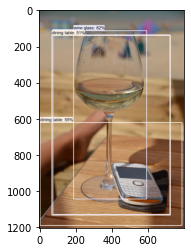

In [55]:
%matplotlib inline
visualise_results(image_01_denorm_res[1], np.array(image_01_pil), False)

#### visualise de norm coordinates

before vis shape 307 307
after vis shape 307 307


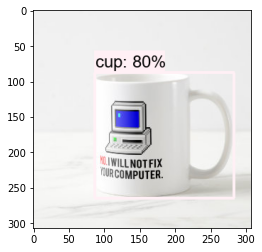

In [27]:
%matplotlib inline
visualise_results(image_01_norm_res[1], np.array(image_01_pil), True)

### visualize ground truth bbox - using cv2.rectangle

In [15]:
img_arr = np.array(Image.open(dataset_path/"image_08.jpg"))

In [16]:
# top-left:(xmin, ymax), bottom-right: (xmax, ymin)
img_box = cv2.rectangle(img_arr,(427,324),(851, 347),(0,255,0),3)
#img_box = cv2.rectangle(img_arr,(49,512),(1819,174),(0,255,0),3)
#img_box = cv2.rectangle(img_arr,(237,568),(1425,165),(255,0,0),3)

In [17]:
img_arr.shape
img_box.shape

(1000, 1600, 3)

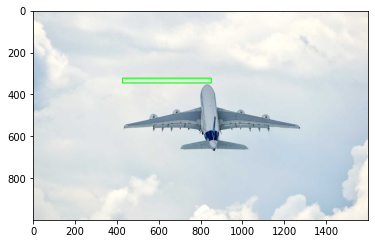

In [18]:
%matplotlib inline
plt.imshow(img_box)
plt.show()

### TO-DO
* our ground truth annotation format - xmin, ymin, width, height
* tensorflow bbox format - ymin, xmin, xmax, ymax

TASKS
* read ground truth in csv.
* store detections in csv.
* try out raffale.peddila python library to calculate the metrics.
* scale to other models.